
# Build monthly SST anomaly forcing (1955–2099) from an annual anomaly CSV

This notebook takes an **annual SST anomaly** time series (e.g., `anomaly_df.csv` with columns `year, anomaly`) and produces:

- A **monthly anomaly** CSV for **1955–2099**
- An **annual anomaly** CSV for **1955–2099** (derived from the monthly series)

This is designed for ecological model forcing where you want a smooth monthly anomaly trajectory but only have annual projections for part of the period.

## Default assumptions (editable)
- Years **before the first provided year** (e.g., before 2021) are set to **0.0°C anomaly**
- Years **after the last provided year** (e.g., 2090–2099) are held at the **last available anomaly**
- Annual values are converted to monthly via **time interpolation** between January-1 anchors

You can switch these behaviors in the settings cell below.


In [10]:
import netCDF4 as nc
import pandas as pd
import numpy as np
from pathlib import Path

# -------------------------
# Find the NetCDF file
# -------------------------

FILENAME = "noaasst.nc"

# 1) Check current directory
candidates = list(Path(".").rglob(FILENAME))

# 2) If not found, search home directory
if not candidates:
    candidates = list(Path.home().rglob(FILENAME))

if not candidates:
    raise FileNotFoundError(
        "Could not find 'noaasst.nc'. Put it next to this notebook or somewhere in your home directory."
    )

nc_path = candidates[0]
print(f"Using NetCDF file: {nc_path}")

# -------------------------
# Read NetCDF (R: nc_open + ncvar_get)
# -------------------------

with nc.Dataset(nc_path, mode="r") as ds:
    print("Variables in file:", list(ds.variables.keys()))
    
    anomaly = np.array(ds.variables["anomaly"][:]).squeeze()
    year = np.array(ds.variables["year"][:]).squeeze()

# -------------------------
# Build dataframe (R: cbind + as.data.frame)
# -------------------------

anomaly_df = pd.DataFrame({
    "year": year.astype(int),
    "anomaly": anomaly.astype(float)
})

# -------------------------
# Filter years (R: filter(year > 2020 & year < 2090))
# -------------------------

anomaly_df = anomaly_df.query("year > 2020 and year < 2090")

# -------------------------
# Write CSV (R: write.csv)
# -------------------------

out_csv = "anomaly_df.csv"
anomaly_df.to_csv(out_csv, index=False)

print(f"Wrote {out_csv}")
anomaly_df.head()


FileNotFoundError: Could not find 'noaasst.nc'. Put it next to this notebook or somewhere in your home directory.

## 0) Imports

In [1]:

import pandas as pd
import numpy as np
from pathlib import Path


## 1) Settings

In [2]:

# -------------------------
# INPUT
# -------------------------
# Put anomaly_df.csv in the same folder as this notebook, or set a full path.
INPUT_CSV = "anomaly_df.csv"   # must contain columns: year, anomaly

# -------------------------
# OUTPUT WINDOW
# -------------------------
START_YEAR = 1955
END_YEAR = 2099

# -------------------------
# BEHAVIOR OUTSIDE PROVIDED YEARS
# -------------------------
# For years before the first year in INPUT_CSV:
PRE_FIRST_YEAR_VALUE = 0.0     # set to np.nan if you prefer missing values

# For years after the last year in INPUT_CSV:
POST_LAST_YEAR_MODE = "hold"   # "hold" or "extrapolate_linear"
# If extrapolating, use the last N years to fit a line:
EXTRAPOLATE_N_YEARS = 10

# -------------------------
# ANNUAL -> MONTHLY INTERPOLATION
# -------------------------
# Anchor annual anomalies at Jan 1 of each year ("jan1") or Jul 1 ("jul1")
ANCHOR = "jan1"  # "jan1" or "jul1"


## 2) Load and validate input

In [3]:

input_path = Path(INPUT_CSV)
if not input_path.exists():
    raise FileNotFoundError(
        f"Could not find {INPUT_CSV!r}. Put it next to this notebook or set INPUT_CSV to the correct path."
    )

df_in = pd.read_csv(input_path)

# Basic validation / cleanup
required = {"year", "anomaly"}
if not required.issubset(df_in.columns):
    raise ValueError(f"Input CSV must contain columns {required}, but has {list(df_in.columns)}")

df_in = df_in[["year", "anomaly"]].copy()
df_in["year"] = df_in["year"].astype(int)
df_in = df_in.sort_values("year").drop_duplicates("year")

first_year = int(df_in["year"].min())
last_year = int(df_in["year"].max())

print("Loaded:", input_path.resolve())
print("Input years:", first_year, "to", last_year)
df_in.head()


Loaded: /Users/SophiaRahnke/Documents/GitHub/pred_prey_coral_algae/anomaly_df.csv
Input years: 2021 to 2089


,year,anomaly
0,2021,0.735704
1,2022,0.762417
2,2023,0.787313
3,2024,0.810814
4,2025,0.840115


## 3) Build a complete annual series (START_YEAR–END_YEAR)

In [4]:

years_full = pd.DataFrame({"year": np.arange(START_YEAR, END_YEAR + 1)})
annual = years_full.merge(df_in, on="year", how="left")

# Fill before first provided year
annual.loc[annual["year"] < first_year, "anomaly"] = PRE_FIRST_YEAR_VALUE

# Fill within provided years: forward-fill is safe if input has gaps; otherwise it does nothing
annual["anomaly"] = annual["anomaly"].ffill()

# Extend after last provided year
if END_YEAR > last_year:
    if POST_LAST_YEAR_MODE == "hold":
        annual.loc[annual["year"] > last_year, "anomaly"] = float(df_in.loc[df_in["year"].idxmax(), "anomaly"])
    elif POST_LAST_YEAR_MODE == "extrapolate_linear":
        # Fit a line to the last N years of available data
        tail = df_in.tail(min(EXTRAPOLATE_N_YEARS, len(df_in))).copy()
        x = tail["year"].values.astype(float)
        y = tail["anomaly"].values.astype(float)
        m, b = np.polyfit(x, y, 1)
        mask = annual["year"] > last_year
        annual.loc[mask, "anomaly"] = m * annual.loc[mask, "year"].values + b
    else:
        raise ValueError("POST_LAST_YEAR_MODE must be 'hold' or 'extrapolate_linear'")

annual.head(10), annual.tail(10)


(   year  anomaly
 0  1955      0.0
 1  1956      0.0
 2  1957      0.0
 3  1958      0.0
 4  1959      0.0
 5  1960      0.0
 6  1961      0.0
 7  1962      0.0
 8  1963      0.0
 9  1964      0.0,
      year   anomaly
 135  2090  2.027231
 136  2091  2.027231
 137  2092  2.027231
 138  2093  2.027231
 139  2094  2.027231
 140  2095  2.027231
 141  2096  2.027231
 142  2097  2.027231
 143  2098  2.027231
 144  2099  2.027231)

## 4) Convert annual anomalies to monthly anomalies (smooth monthly series)

In [5]:

# Monthly timeline (month starts)
monthly_dates = pd.date_range(f"{START_YEAR}-01-01", f"{END_YEAR}-12-01", freq="MS")

# Choose anchor dates for annual anomalies
if ANCHOR.lower() == "jan1":
    anchor_dates = pd.to_datetime(annual["year"].astype(str) + "-01-01")
elif ANCHOR.lower() == "jul1":
    anchor_dates = pd.to_datetime(annual["year"].astype(str) + "-07-01")
else:
    raise ValueError("ANCHOR must be 'jan1' or 'jul1'")

anchors = pd.Series(annual["anomaly"].values, index=anchor_dates).sort_index()

# Ensure endpoints exist for interpolation
anchors.loc[pd.Timestamp(f"{START_YEAR}-01-01")] = anchors.loc[pd.Timestamp(f"{START_YEAR}-01-01")] if pd.Timestamp(f"{START_YEAR}-01-01") in anchors.index else PRE_FIRST_YEAR_VALUE
anchors.loc[pd.Timestamp(f"{END_YEAR}-01-01")] = anchors.loc[pd.Timestamp(f"{END_YEAR}-01-01")] if pd.Timestamp(f"{END_YEAR}-01-01") in anchors.index else anchors.iloc[-1]
anchors = anchors.sort_index()

# Interpolate to monthly
monthly = anchors.reindex(anchors.index.union(monthly_dates)).sort_index().interpolate(method="time")
monthly = monthly.reindex(monthly_dates).ffill().bfill()

monthly_df = pd.DataFrame({"time": monthly.index, "anomaly_C": monthly.values})
monthly_df["year"] = monthly_df["time"].dt.year
monthly_df["month"] = monthly_df["time"].dt.month

monthly_df.head(12), monthly_df.tail(12)


(         time  anomaly_C  year  month
 0  1955-01-01        0.0  1955      1
 1  1955-02-01        0.0  1955      2
 2  1955-03-01        0.0  1955      3
 3  1955-04-01        0.0  1955      4
 4  1955-05-01        0.0  1955      5
 5  1955-06-01        0.0  1955      6
 6  1955-07-01        0.0  1955      7
 7  1955-08-01        0.0  1955      8
 8  1955-09-01        0.0  1955      9
 9  1955-10-01        0.0  1955     10
 10 1955-11-01        0.0  1955     11
 11 1955-12-01        0.0  1955     12,
            time  anomaly_C  year  month
 1728 2099-01-01   2.027231  2099      1
 1729 2099-02-01   2.027231  2099      2
 1730 2099-03-01   2.027231  2099      3
 1731 2099-04-01   2.027231  2099      4
 1732 2099-05-01   2.027231  2099      5
 1733 2099-06-01   2.027231  2099      6
 1734 2099-07-01   2.027231  2099      7
 1735 2099-08-01   2.027231  2099      8
 1736 2099-09-01   2.027231  2099      9
 1737 2099-10-01   2.027231  2099     10
 1738 2099-11-01   2.027231  2099     11


## 5) Derive annual anomalies from the monthly series

In [6]:

annual_df = monthly_df.groupby("year", as_index=False)["anomaly_C"].mean()
annual_df.head(), annual_df.tail()


(   year  anomaly_C
 0  1955        0.0
 1  1956        0.0
 2  1957        0.0
 3  1958        0.0
 4  1959        0.0,
      year  anomaly_C
 140  2095   2.027231
 141  2096   2.027231
 142  2097   2.027231
 143  2098   2.027231
 144  2099   2.027231)

## 6) Save outputs

In [7]:

monthly_out = Path(f"insular_pacific_hawaii_sst_anomaly_monthly_{START_YEAR}_{END_YEAR}_from_paper.csv")
annual_out  = Path(f"insular_pacific_hawaii_sst_anomaly_annual_{START_YEAR}_{END_YEAR}_from_paper.csv")

monthly_df.to_csv(monthly_out, index=False)
annual_df.to_csv(annual_out, index=False)

print("Wrote:", monthly_out.resolve())
print("Wrote:", annual_out.resolve())


Wrote: /Users/SophiaRahnke/Documents/GitHub/pred_prey_coral_algae/insular_pacific_hawaii_sst_anomaly_monthly_1955_2099_from_paper.csv
Wrote: /Users/SophiaRahnke/Documents/GitHub/pred_prey_coral_algae/insular_pacific_hawaii_sst_anomaly_annual_1955_2099_from_paper.csv


## 7) Quick plots (optional)

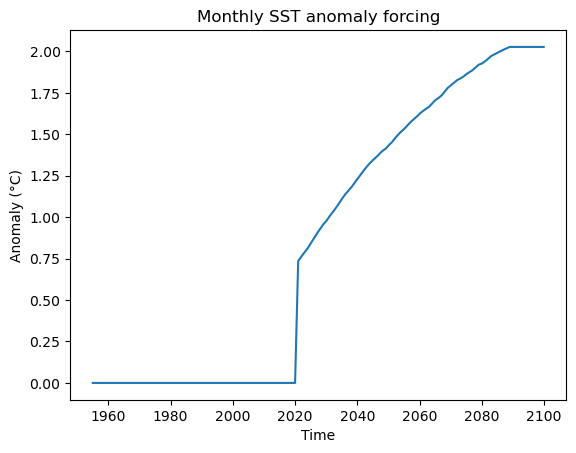

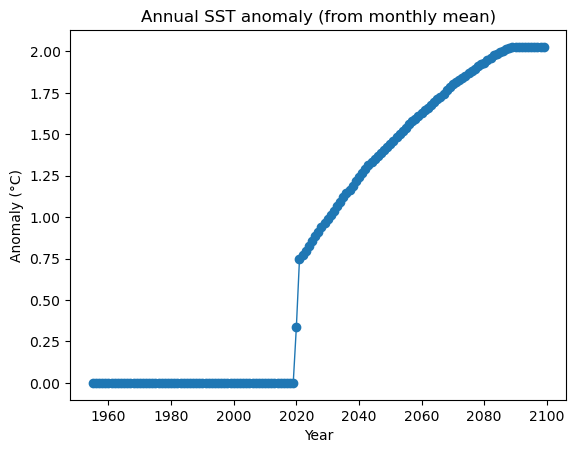

In [8]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(monthly_df["time"], monthly_df["anomaly_C"])
plt.title("Monthly SST anomaly forcing")
plt.xlabel("Time")
plt.ylabel("Anomaly (°C)")
plt.show()

plt.figure()
plt.plot(annual_df["year"], annual_df["anomaly_C"], marker="o", linewidth=1)
plt.title("Annual SST anomaly (from monthly mean)")
plt.xlabel("Year")
plt.ylabel("Anomaly (°C)")
plt.show()
